In [1]:
import numpy as np
import csv
f = open("../data/zoo.csv", "r")
reader = csv.reader(f)
data=[]
for row in reader:
    data.append(row)
data=np.array(data[1:])[:,1:-1].astype(int)
data[data>1]=1
top_features=np.argsort(np.var(data,axis=0))[1:]

In [2]:
## 데이터 set :  https://www.kaggle.com/datasets/uciml/zoo-animal-classification/data

## zoo.csv

![image.png](attachment:3e5fc267-a92a-464d-95f6-b5361abf38b4.png)

In [2]:
import numpy as np
import random
from scipy.stats import beta
import scipy.special as sp

class CRP_Classifier:
    def __init__(self, alpha=1.0, delta=1.0, bin_cmp=True):
        self.alpha = alpha  # CRP 집중도
        self.delta = delta  # 베타 분포의 매개변수
        self.categories = []  # 각 카테고리의 feature 집합
        self.assignments = []  # 동물별 카테고리 할당 정보
        self.total_animals=0
        self.labels=[]
        self.bin_cmp=bin_cmp
    def crp_prior(self):

        if len(self.categories) == 0:
            return [1]

        probs = [len(cat) / (self.total_animals + self.alpha -1) for cat in self.categories]
        probs.append(self.alpha / (self.total_animals + self.alpha-1))  # 새로운 카테고리 확률
        return probs

    def beta_likelihood(self, category, features):
        #베타-이항 분포를 이용하여 특정 카테고리에 속할 확률을 평가
        if len(category) == 0:
            return 1.0
        else:
            n_class_feature=0
            for animal in category:
                if self.bin_cmp:
                    n_class_feature += np.all(features == animal)   # feature가 모두 동일한 경우 count
                else:
                    n_class_feature += np.mean(features == animal)  # feature가 동일한 정도 average

            not_n_class_feature = len(category) - n_class_feature
            return sp.beta(n_class_feature + self.delta, not_n_class_feature + self.delta) / sp.beta(self.delta, self.delta)

    def assign_animal(self, features):
        self.total_animals+=1

        #새로운 동물의 특징을 보고 CRP를 통해 카테고리 할당

        probs = self.crp_prior()
        likelihoods=[]
        for cat in self.categories:
            likelihoods.append(self.beta_likelihood(cat, features))
        likelihoods +=[1]

        posteriors = np.array(probs)*np.array(likelihoods)


        # 맨 처음 assign이면 0
        total = sum(posteriors)
        if self.total_animals == 1:
            self.categories.append([features])  # 새로운 카테고리 생성
            self.assignments.append(0)
            return


        posteriors = np.array(posteriors) / total
        chosen_category = np.random.choice(len(posteriors), p=posteriors)

        if chosen_category == len(self.categories):
            self.categories.append([features])
        else:
            self.categories[chosen_category].append(features)

        self.assignments.append(chosen_category)

    def classify(self, data):
        for animal in data:
            self.assign_animal(animal)

    def get_categories(self):

        return self.categories

Text(0, 0.5, 'Features')

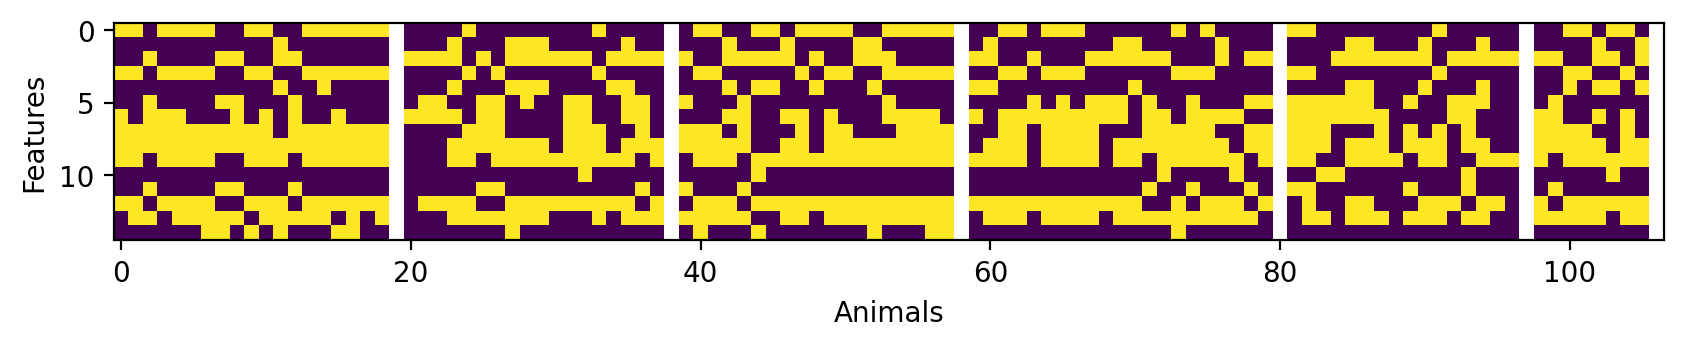

In [3]:
import matplotlib.pyplot as plt

np.random.seed(12)
model = CRP_Classifier(alpha=0.0001, delta=1,bin_cmp=False)
model.classify(data[:,:-1])
categories = model.get_categories()

plt.figure(figsize=(10,10),dpi=200)
total_clusters=[]
count=0
for i, cluster in enumerate(categories):
    total_clusters+=cluster
    total_clusters+=[[np.nan]*len(cluster[0])]
    count+=len(cluster)
total_clusters=np.array(total_clusters)
total_clusters[total_clusters>1]=1
plt.imshow(np.array(total_clusters).T)
plt.xlabel('Animals')
plt.ylabel('Features')

Text(0.5, 1.0, 'Answer')

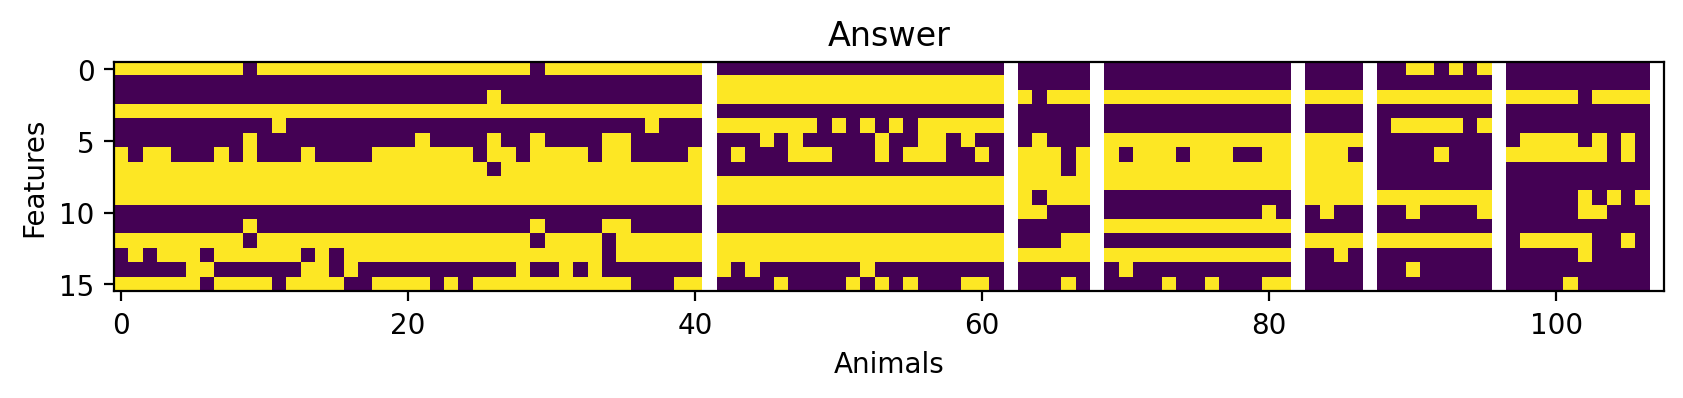

In [5]:
import csv
f = open("../data/zoo.csv", "r")
reader = csv.reader(f)
data=[]
for row in reader:
    data.append(row)
data=np.array(data[1:])[:,1:].astype(int)
answer=[[],[],[],[],[],[],[]]

for animal in data:
    answer[animal[-1]-1].append(animal[:-1])
plt.figure(figsize=(10,10),dpi=200)

total_clusters=[]
count=0
for i, cluster in enumerate(answer):
    total_clusters+=cluster
    total_clusters+=[[np.nan]*len(cluster[0])]
    count+=len(cluster)
total_clusters=np.array(total_clusters)
total_clusters[total_clusters>1]=1
plt.imshow(np.array(total_clusters).T)
plt.xlabel('Animals')
plt.ylabel('Features')
plt.title('Answer')

# 발표자료 데이터로 CRP

Text(0, 0.5, 'Features')

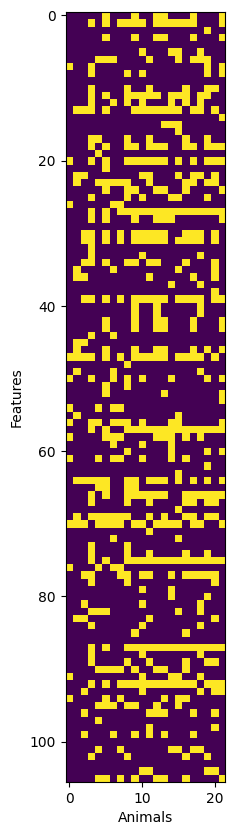

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(np.load('../data/binary_mat.npy'))
data2=np.load('../data/binary_mat.npy')
plt.xlabel('Animals')
plt.ylabel('Features')

Text(0, 0.5, 'Features')

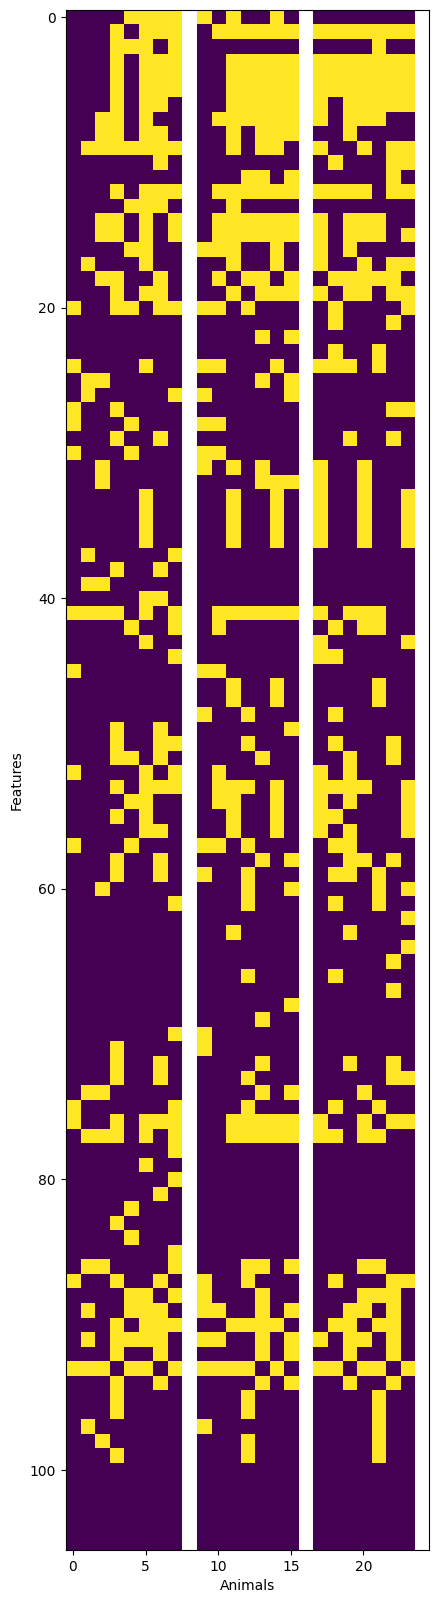

In [8]:
np.random.seed(12)
model = CRP_Classifier(alpha=0.01, delta=1,bin_cmp=False)
model.classify(data2.T)
categories = model.get_categories()

plt.figure(figsize=(10,20),dpi=100)
total_clusters=[]
count=0
mean_list=[]
for i, cluster in enumerate(categories):
    total_clusters+=cluster
    total_clusters+=[[np.nan]*len(cluster[0])]
    count+=len(cluster)
    mean_list.append(np.mean(cluster,axis=0))

var_order=np.argsort(-np.var(mean_list,axis=0))
total_clusters=np.array(total_clusters)
total_clusters[total_clusters>1]=1
plt.imshow(np.array(total_clusters).T[var_order])
plt.xlabel('Animals')
plt.ylabel('Features')

# Feature PCA

In [9]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
transformed_matrix = pca.fit_transform(data2.T)


In [10]:
transformed_matrix.shape

(22, 10)

Text(0, 0.5, 'PC')

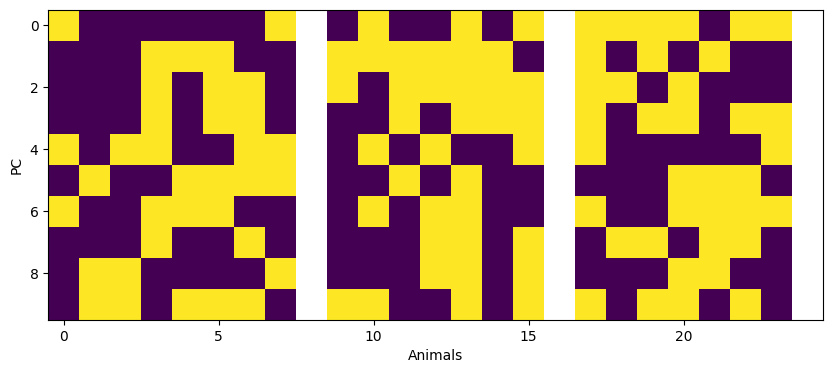

In [11]:
np.random.seed(12)
model = CRP_Classifier(alpha=0.01, delta=1,bin_cmp=False)
model.classify(transformed_matrix>0)
categories = model.get_categories()

plt.figure(figsize=(10,20))
total_clusters=[]
count=0
mean_list=[]
for i, cluster in enumerate(categories):
    total_clusters+=cluster
    total_clusters+=[[np.nan]*len(cluster[0])]
    count+=len(cluster)
    mean_list.append(np.mean(cluster,axis=0))

var_order=np.argsort(-np.max(mean_list,axis=0)*np.var(mean_list,axis=0))
total_clusters=np.array(total_clusters)
total_clusters[total_clusters>1]=1
plt.imshow(np.array(total_clusters).T[var_order])
plt.xlabel('Animals')
plt.ylabel('PC')

#